<a href="https://colab.research.google.com/github/nluninja/text-mining-dataviz-aa2526/blob/main/01-NLP_In_Practice/NLP01-10_EDA-Text-Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

___
1.10 NLP in Practice

___

# Exploratory Data Analysis on Text Data

In this notebook we'll apply everything we've learned so far to perform **Exploratory Data Analysis (EDA)** on a real text dataset. We'll use spaCy for NLP processing and matplotlib/seaborn for visualization.

**Dataset:** 20 Newsgroups - a classic dataset for text classification containing ~20,000 newsgroup posts across 20 topics.

# Setup

In [1]:
!pip install -U spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 59.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Load the Dataset

The 20 Newsgroups dataset is available directly from scikit-learn.

In [3]:
from sklearn.datasets import fetch_20newsgroups

# Load a subset of categories for faster processing
categories = ['sci.space', 'rec.sport.baseball', 'comp.graphics', 'talk.politics.misc']

newsgroups = fetch_20newsgroups(
    subset='train',
    categories=categories,
    remove=('headers', 'footers', 'quotes')  # Remove metadata for cleaner text
)

print(f"Number of documents: {len(newsgroups.data)}")
print(f"Categories: {newsgroups.target_names}")

Number of documents: 2239
Categories: ['comp.graphics', 'rec.sport.baseball', 'sci.space', 'talk.politics.misc']


In [4]:
# Create a DataFrame
df = pd.DataFrame({
    'text': newsgroups.data,
    'category': [newsgroups.target_names[i] for i in newsgroups.target]
})

df.head()

,text,category
0,I thought that was Sandy Koufax.,rec.sport.baseball
1,"\nAnd the religious right worships engines, sm...",talk.politics.misc
2,\nHow can a witness tell that someone in a bur...,talk.politics.misc
3,"\n\n\n\nYes, long before Star Trek. Before Ei...",sci.space
4,\n\nIt depends. If you can get your old veter...,rec.sport.baseball


In [5]:
# Look at a sample document
print("Sample document:")
print("-" * 50)
print(df['text'].iloc[0][:500])

Sample document:
--------------------------------------------------
I thought that was Sandy Koufax.


# Basic Statistics

In [6]:
# Add text length columns
df['char_count'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

df[['category', 'char_count', 'word_count']].head(10)

,category,char_count,word_count
0,rec.sport.baseball,32,6
1,talk.politics.misc,1595,245
2,talk.politics.misc,757,134
3,sci.space,359,56
4,rec.sport.baseball,517,93
5,comp.graphics,451,75
6,comp.graphics,1067,180
7,rec.sport.baseball,0,0
8,sci.space,531,89
9,sci.space,4432,598


In [7]:
# Summary statistics
df[['char_count', 'word_count']].describe()

,char_count,word_count
count,2239.000000,2239.000000
mean,1167.407771,186.625726
std,3743.286186,565.337405
min,0.000000,0.000000
25%,214.000000,36.000000
50%,434.000000,72.000000
75%,896.000000,150.000000
max,60218.000000,9109.000000


# Category Distribution

/tmp/ipython-input-715526927.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.values, y=category_counts.index, palette='viridis')


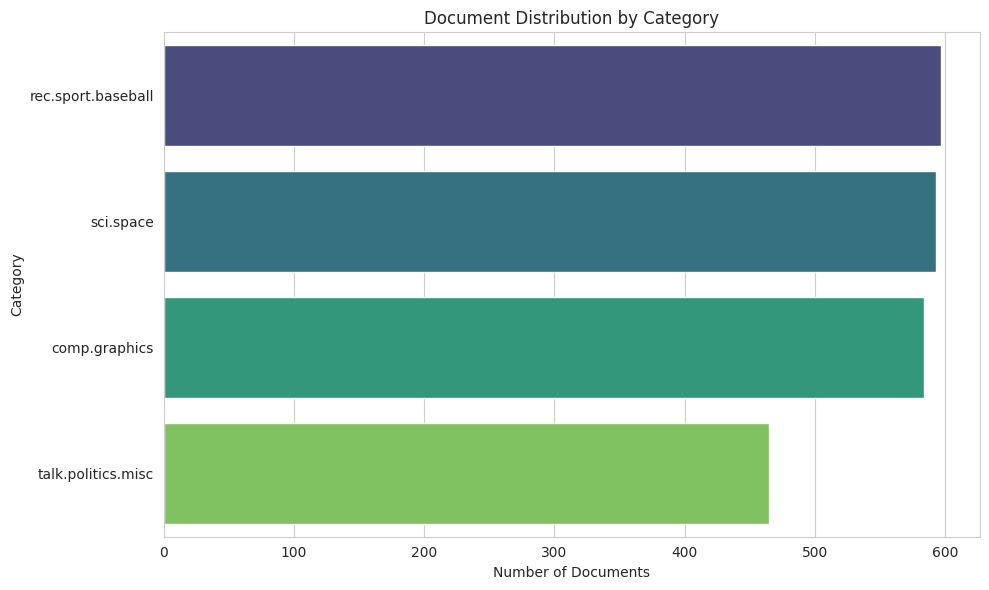

In [8]:
# Count documents per category
category_counts = df['category'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.values, y=category_counts.index, palette='viridis')
plt.xlabel('Number of Documents')
plt.ylabel('Category')
plt.title('Document Distribution by Category')
plt.tight_layout()
plt.show()

# Text Length Distribution

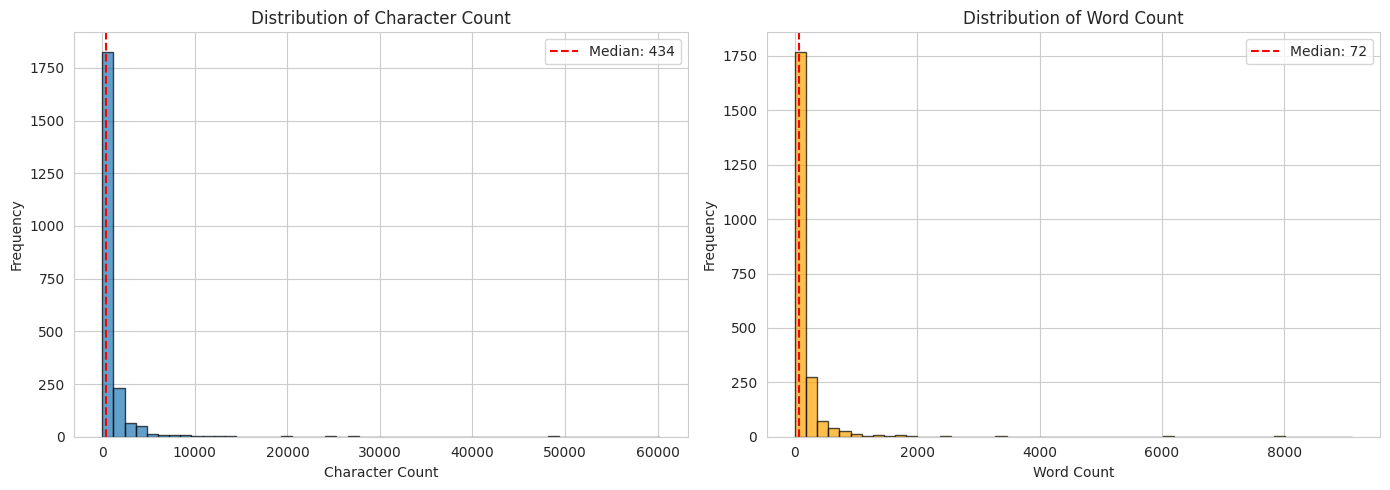

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Character count distribution
axes[0].hist(df['char_count'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Character Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Character Count')
axes[0].axvline(df['char_count'].median(), color='red', linestyle='--', label=f'Median: {df["char_count"].median():.0f}')
axes[0].legend()

# Word count distribution
axes[1].hist(df['word_count'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Word Count')
axes[1].axvline(df['word_count'].median(), color='red', linestyle='--', label=f'Median: {df["word_count"].median():.0f}')
axes[1].legend()

plt.tight_layout()
plt.show()

/tmp/ipython-input-2812105394.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='category', y='word_count', palette='Set2')


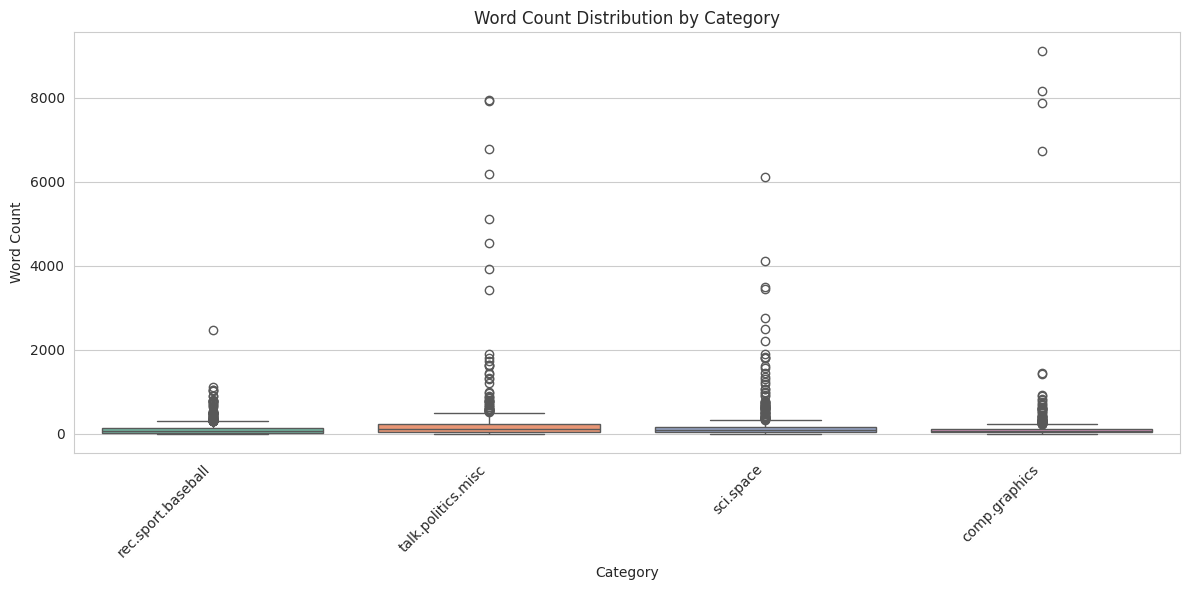

In [10]:
# Text length by category
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='category', y='word_count', palette='Set2')
plt.xlabel('Category')
plt.ylabel('Word Count')
plt.title('Word Count Distribution by Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# NLP Processing with spaCy

Now let's process the texts with spaCy to extract linguistic features.

In [11]:
# Process a sample of documents (full dataset would take too long)
# We'll use nlp.pipe for efficiency

sample_size = 500
df_sample = df.sample(n=sample_size, random_state=42).reset_index(drop=True)

print(f"Processing {sample_size} documents with spaCy...")

# Process with spaCy
docs = list(nlp.pipe(df_sample['text'], batch_size=50))

print("Done!")

Processing 500 documents with spaCy...
Done!


# Token Analysis

In [12]:
# Extract tokens (excluding punctuation and spaces)
all_tokens = []
all_tokens_no_stop = []

for doc in docs:
    for token in doc:
        if not token.is_punct and not token.is_space:
            all_tokens.append(token.text.lower())
            if not token.is_stop:
                all_tokens_no_stop.append(token.text.lower())

print(f"Total tokens: {len(all_tokens)}")
print(f"Tokens without stopwords: {len(all_tokens_no_stop)}")
print(f"Unique tokens: {len(set(all_tokens))}")
print(f"Unique tokens (no stopwords): {len(set(all_tokens_no_stop))}")

Total tokens: 99653
Tokens without stopwords: 51927
Unique tokens: 12717
Unique tokens (no stopwords): 12431


/tmp/ipython-input-1041099933.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='Blues_d')


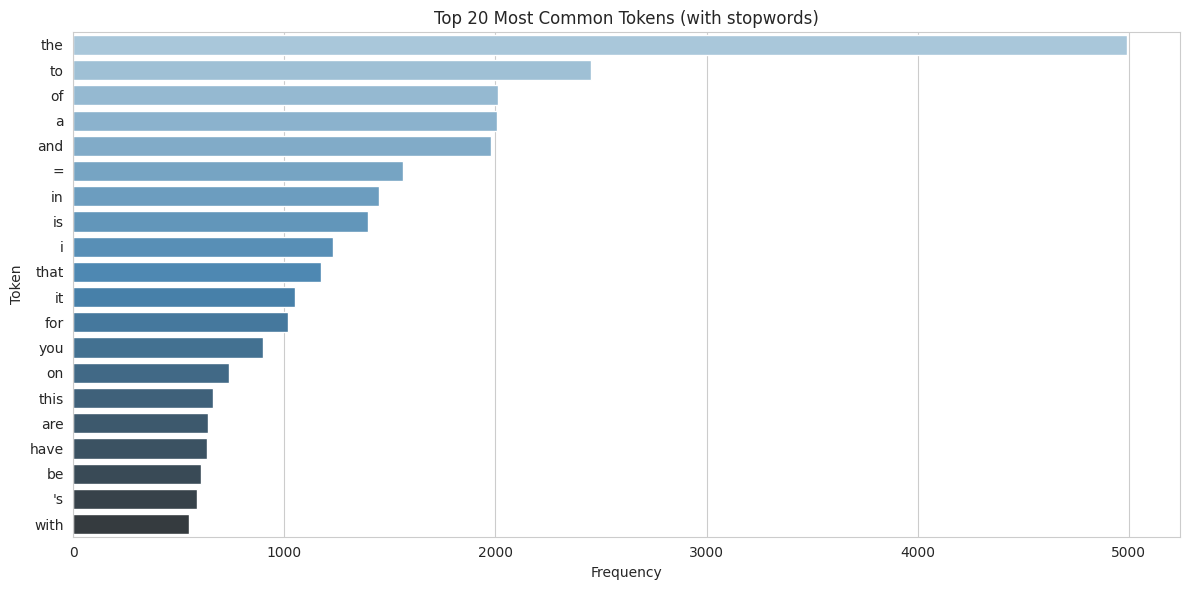

In [13]:
# Top 20 most common tokens (with stopwords)
token_freq = Counter(all_tokens)
top_tokens = token_freq.most_common(20)

plt.figure(figsize=(12, 6))
words, counts = zip(*top_tokens)
sns.barplot(x=list(counts), y=list(words), palette='Blues_d')
plt.xlabel('Frequency')
plt.ylabel('Token')
plt.title('Top 20 Most Common Tokens (with stopwords)')
plt.tight_layout()
plt.show()

/tmp/ipython-input-1830705529.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='Greens_d')


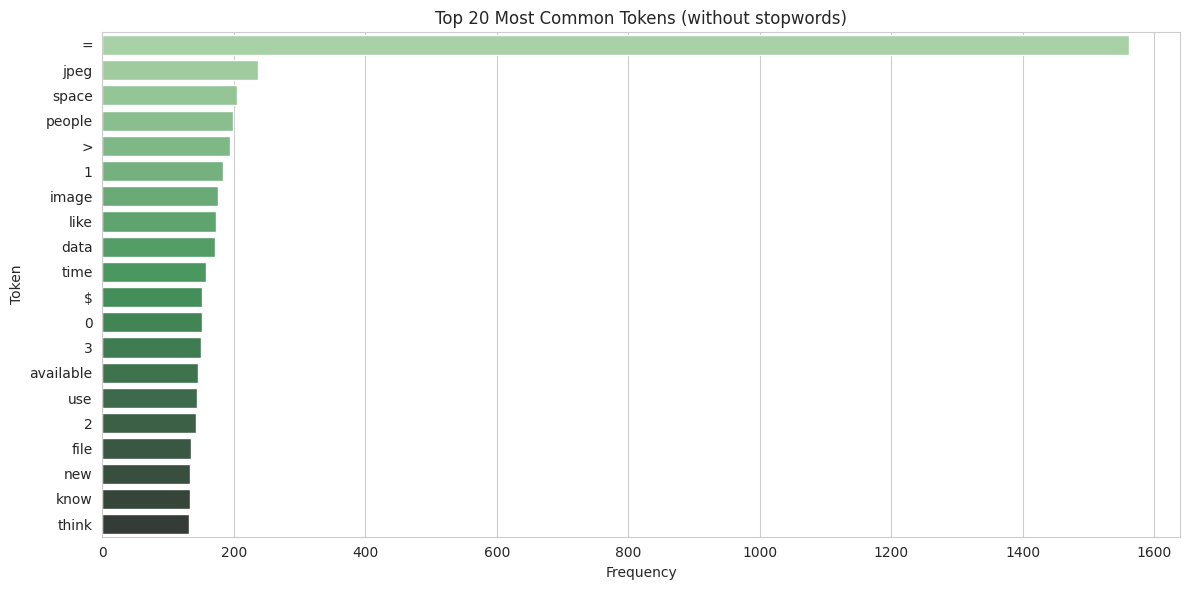

In [14]:
# Top 20 most common tokens (without stopwords)
token_freq_no_stop = Counter(all_tokens_no_stop)
top_tokens_no_stop = token_freq_no_stop.most_common(20)

plt.figure(figsize=(12, 6))
words, counts = zip(*top_tokens_no_stop)
sns.barplot(x=list(counts), y=list(words), palette='Greens_d')
plt.xlabel('Frequency')
plt.ylabel('Token')
plt.title('Top 20 Most Common Tokens (without stopwords)')
plt.tight_layout()
plt.show()

# Lemma Analysis

Comparing tokens vs lemmas to see the effect of lemmatization.

In [15]:
# Extract lemmas
all_lemmas = []

for doc in docs:
    for token in doc:
        if not token.is_punct and not token.is_space and not token.is_stop:
            all_lemmas.append(token.lemma_.lower())

print(f"Unique tokens (no stopwords): {len(set(all_tokens_no_stop))}")
print(f"Unique lemmas (no stopwords): {len(set(all_lemmas))}")
print(f"Vocabulary reduction: {(1 - len(set(all_lemmas))/len(set(all_tokens_no_stop)))*100:.1f}%")

Unique tokens (no stopwords): 12431
Unique lemmas (no stopwords): 10697
Vocabulary reduction: 13.9%


/tmp/ipython-input-675906181.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='Oranges_d')


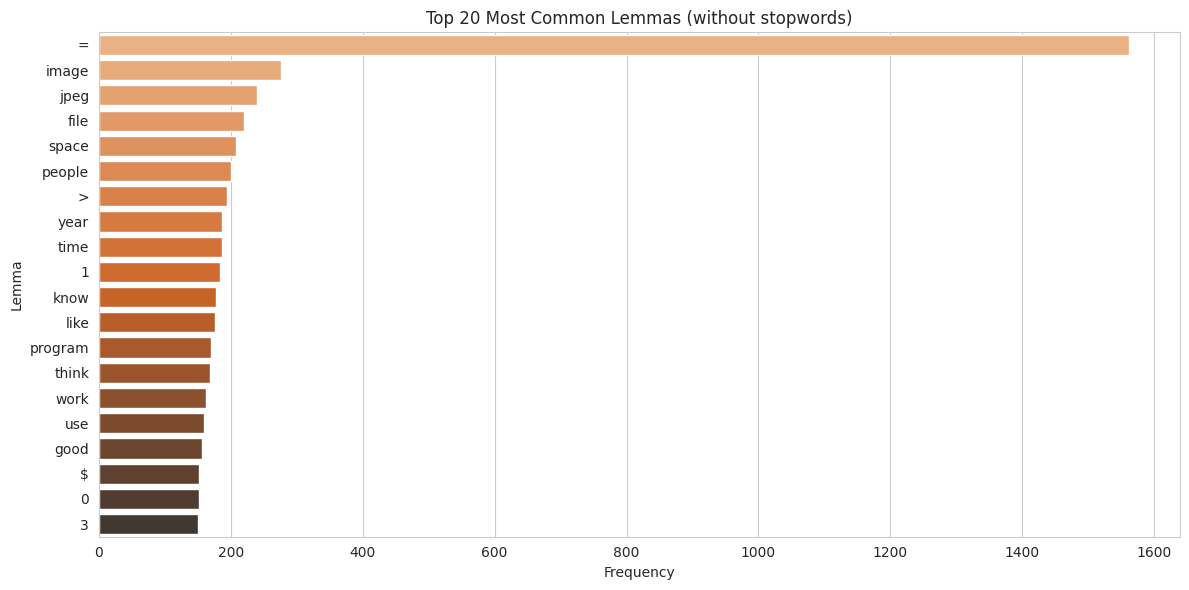

In [16]:
# Top 20 most common lemmas
lemma_freq = Counter(all_lemmas)
top_lemmas = lemma_freq.most_common(20)

plt.figure(figsize=(12, 6))
words, counts = zip(*top_lemmas)
sns.barplot(x=list(counts), y=list(words), palette='Oranges_d')
plt.xlabel('Frequency')
plt.ylabel('Lemma')
plt.title('Top 20 Most Common Lemmas (without stopwords)')
plt.tight_layout()
plt.show()

# Part of Speech (POS) Distribution

In [17]:
# Extract POS tags
pos_tags = []

for doc in docs:
    for token in doc:
        if not token.is_punct and not token.is_space:
            pos_tags.append(token.pos_)

pos_freq = Counter(pos_tags)
print("POS Tag Distribution:")
for pos, count in pos_freq.most_common():
    print(f"  {pos}: {count} ({count/len(pos_tags)*100:.1f}%)")

POS Tag Distribution:
  NOUN: 20734 (20.8%)
  PROPN: 11399 (11.4%)
  VERB: 10685 (10.7%)
  ADP: 9797 (9.8%)
  DET: 8744 (8.8%)
  PRON: 7790 (7.8%)
  ADJ: 6895 (6.9%)
  AUX: 6503 (6.5%)
  ADV: 4466 (4.5%)
  NUM: 3658 (3.7%)
  CCONJ: 2944 (3.0%)
  PART: 2879 (2.9%)
  SCONJ: 2154 (2.2%)
  X: 458 (0.5%)
  INTJ: 271 (0.3%)
  SYM: 177 (0.2%)
  PUNCT: 99 (0.1%)


/tmp/ipython-input-2028915580.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pos_df, x='POS', y='Count', palette='Spectral')


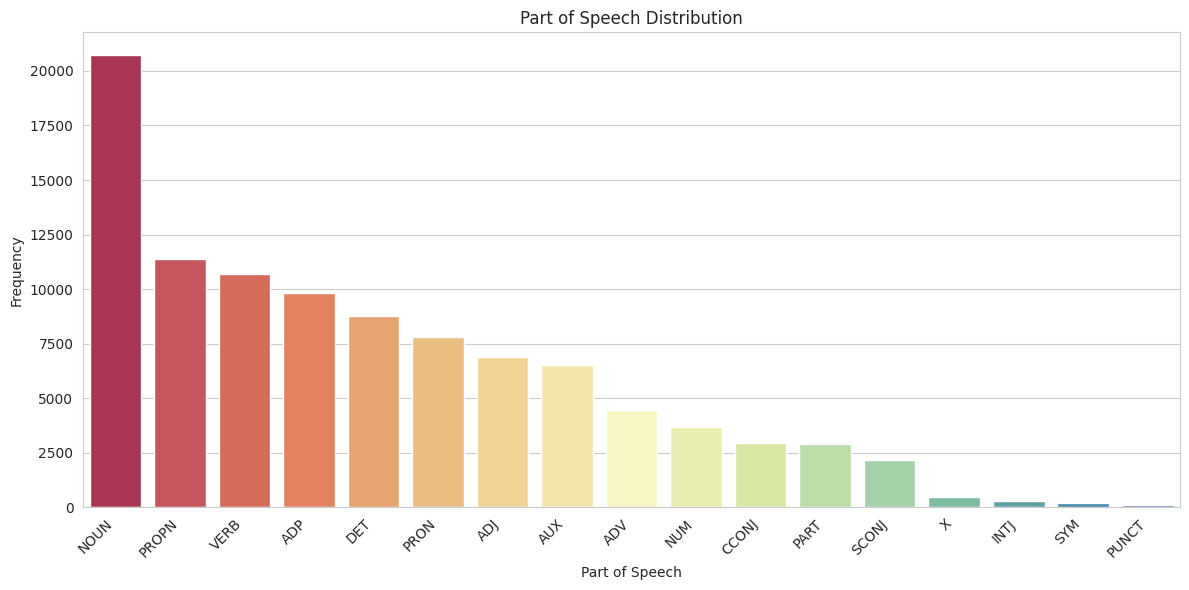

In [18]:
# POS distribution visualization
pos_df = pd.DataFrame(pos_freq.most_common(), columns=['POS', 'Count'])

plt.figure(figsize=(12, 6))
sns.barplot(data=pos_df, x='POS', y='Count', palette='Spectral')
plt.xlabel('Part of Speech')
plt.ylabel('Frequency')
plt.title('Part of Speech Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

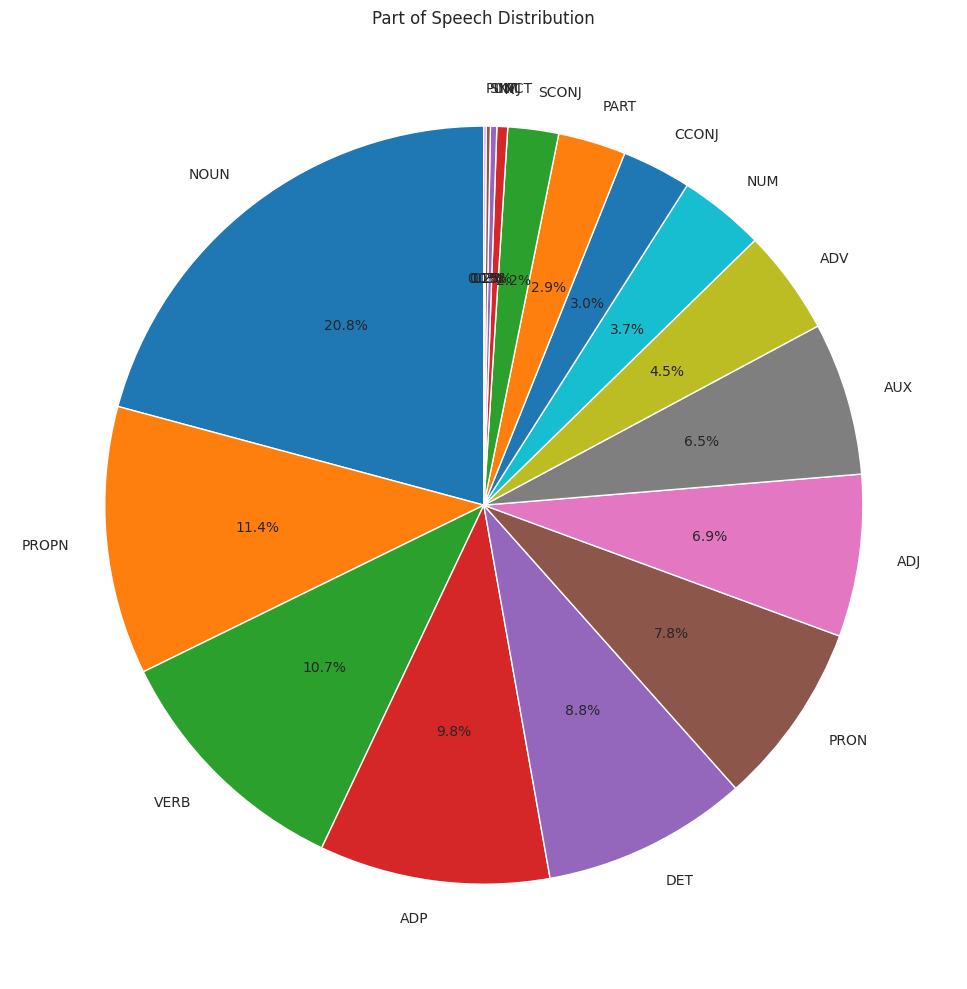

In [19]:
# POS distribution as pie chart
plt.figure(figsize=(10, 10))
plt.pie(pos_df['Count'], labels=pos_df['POS'], autopct='%1.1f%%', startangle=90)
plt.title('Part of Speech Distribution')
plt.tight_layout()
plt.show()

# Named Entity Recognition (NER) Analysis

In [20]:
# Extract named entities
entities = []
entity_labels = []

for doc in docs:
    for ent in doc.ents:
        entities.append(ent.text)
        entity_labels.append(ent.label_)

print(f"Total entities found: {len(entities)}")
print(f"Unique entities: {len(set(entities))}")

Total entities found: 8951
Unique entities: 4587


/tmp/ipython-input-1670943867.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=label_df, x='Entity Type', y='Count', palette='coolwarm')


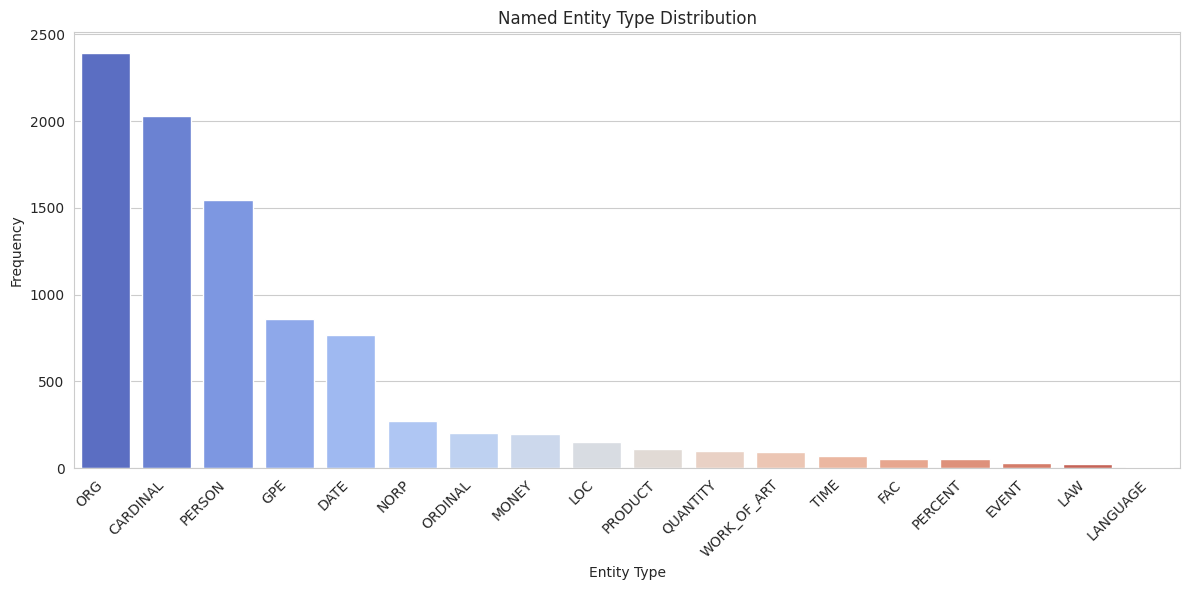

In [21]:
# Entity type distribution
label_freq = Counter(entity_labels)
label_df = pd.DataFrame(label_freq.most_common(), columns=['Entity Type', 'Count'])

plt.figure(figsize=(12, 6))
sns.barplot(data=label_df, x='Entity Type', y='Count', palette='coolwarm')
plt.xlabel('Entity Type')
plt.ylabel('Frequency')
plt.title('Named Entity Type Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [22]:
# Top entities by type
entity_df = pd.DataFrame({'entity': entities, 'label': entity_labels})

# Top PERSON entities
print("Top 10 PERSON entities:")
print(entity_df[entity_df['label'] == 'PERSON']['entity'].value_counts().head(10))
print()

# Top ORG entities
print("Top 10 ORG entities:")
print(entity_df[entity_df['label'] == 'ORG']['entity'].value_counts().head(10))
print()

# Top GPE (geopolitical entity) entities
print("Top 10 GPE entities:")
print(entity_df[entity_df['label'] == 'GPE']['entity'].value_counts().head(10))

Top 10 PERSON entities:
entity
Usenet      17
JFIF        14
Moon        11
Dodgers     10
Clinton     10
Alomar       9
Bob          9
Fred         8
Mitchell     8
Bush         8
Name: count, dtype: int64

Top 10 ORG entities:
entity
GIF            95
JPEG           86
NASA           77
FTP            59
Rockefeller    40
IBM            25
FAQ            25
SGI            25
Congress       19
DOS            16
Name: count, dtype: int64

Top 10 GPE entities:
entity
Russia                  34
Argentina               26
South Georgia Island    22
America                 21
the United States       19
Bolsheviks              18
New York                17
Toronto                 16
Simtel20                16
Britain                 15
Name: count, dtype: int64


/tmp/ipython-input-3061673357.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_ents.values, y=top_ents.index, palette=color, ax=ax)
/tmp/ipython-input-3061673357.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_ents.values, y=top_ents.index, palette=color, ax=ax)
/tmp/ipython-input-3061673357.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_ents.values, y=top_ents.index, palette=color, ax=ax)


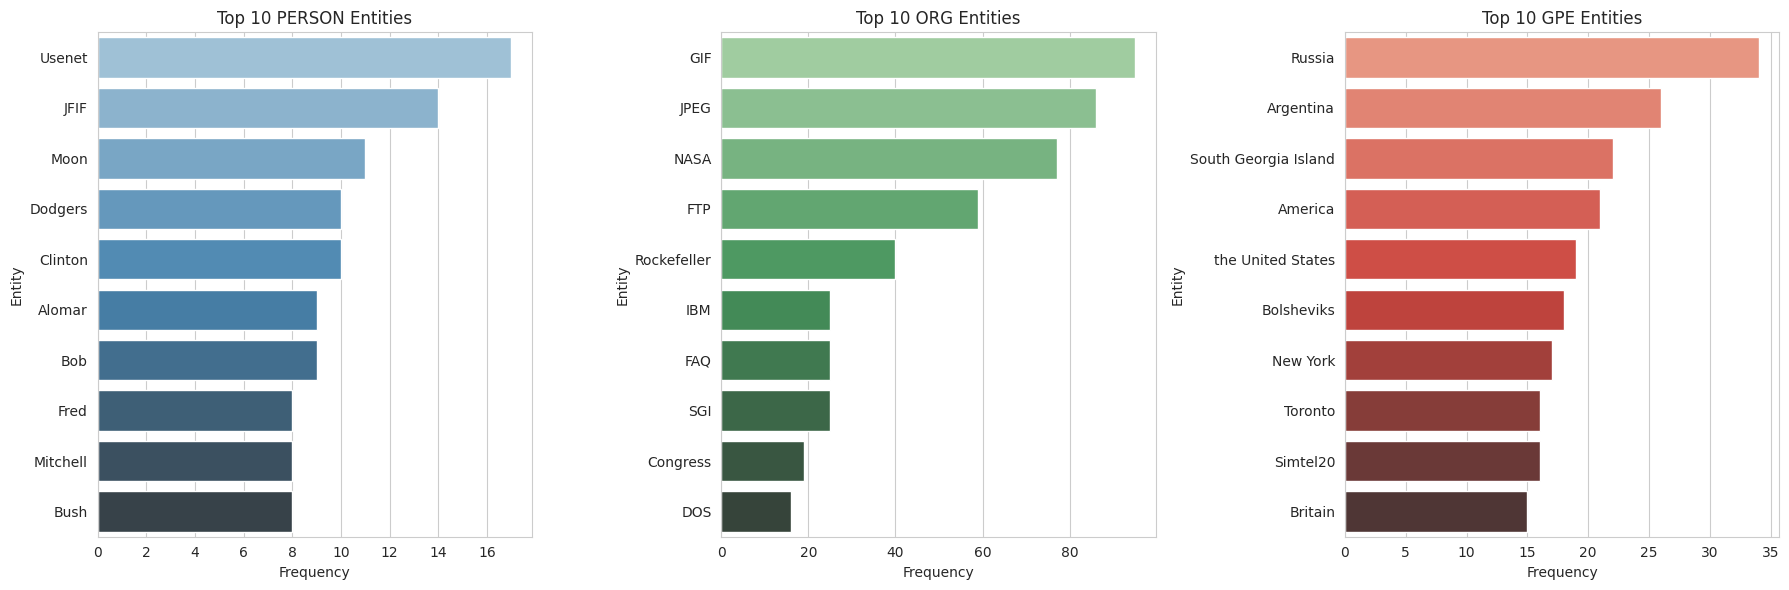

In [23]:
# Visualize top entities
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, label, color in zip(axes, ['PERSON', 'ORG', 'GPE'], ['Blues_d', 'Greens_d', 'Reds_d']):
    top_ents = entity_df[entity_df['label'] == label]['entity'].value_counts().head(10)
    if len(top_ents) > 0:
        sns.barplot(x=top_ents.values, y=top_ents.index, palette=color, ax=ax)
        ax.set_xlabel('Frequency')
        ax.set_ylabel('Entity')
        ax.set_title(f'Top 10 {label} Entities')

plt.tight_layout()
plt.show()

# Word Cloud Visualization

In [24]:
!pip install wordcloud

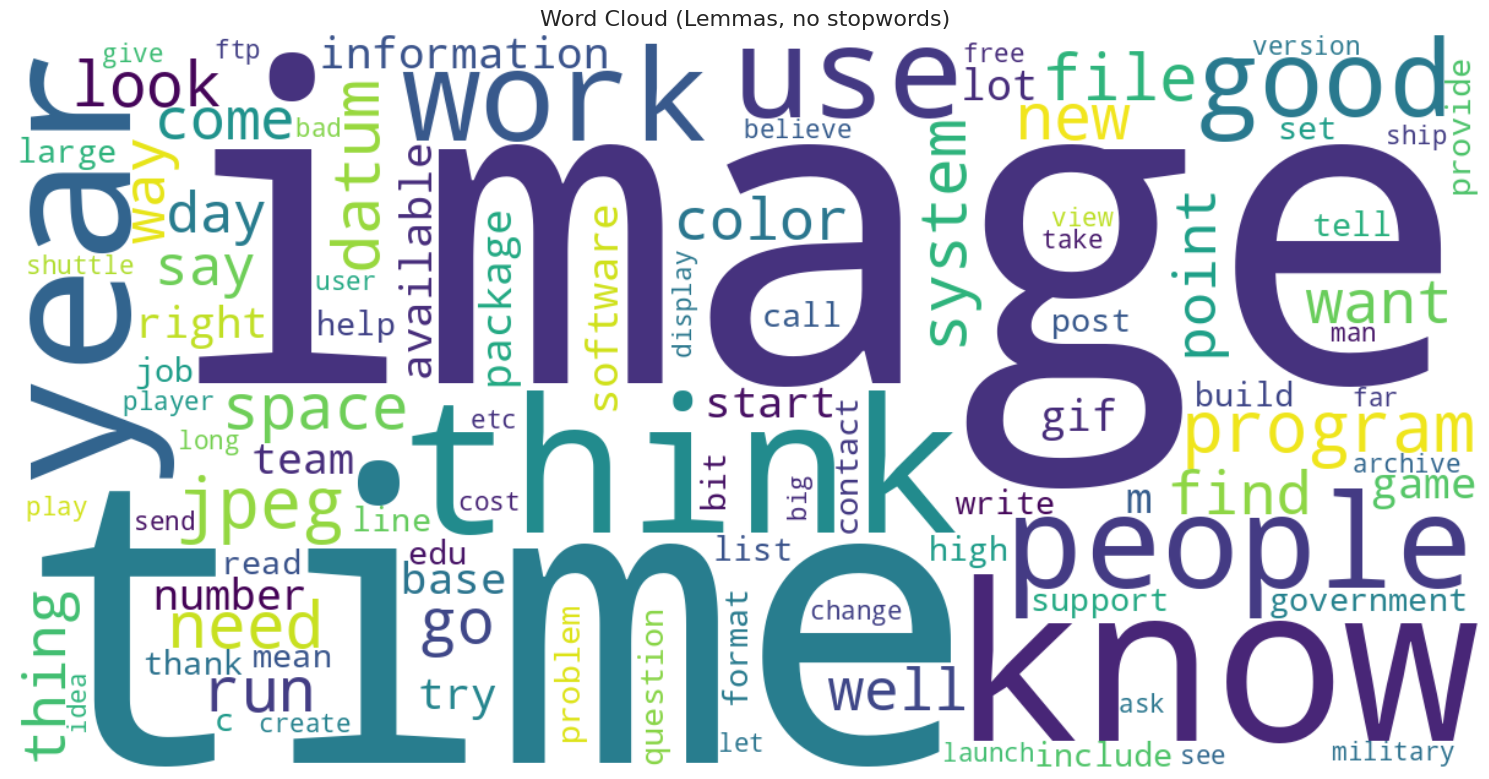

In [25]:
from wordcloud import WordCloud

# Create word cloud from lemmas (no stopwords)
text_for_wordcloud = ' '.join(all_lemmas)

wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    colormap='viridis',
    max_words=100
).generate(text_for_wordcloud)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Lemmas, no stopwords)', fontsize=16)
plt.tight_layout()
plt.show()

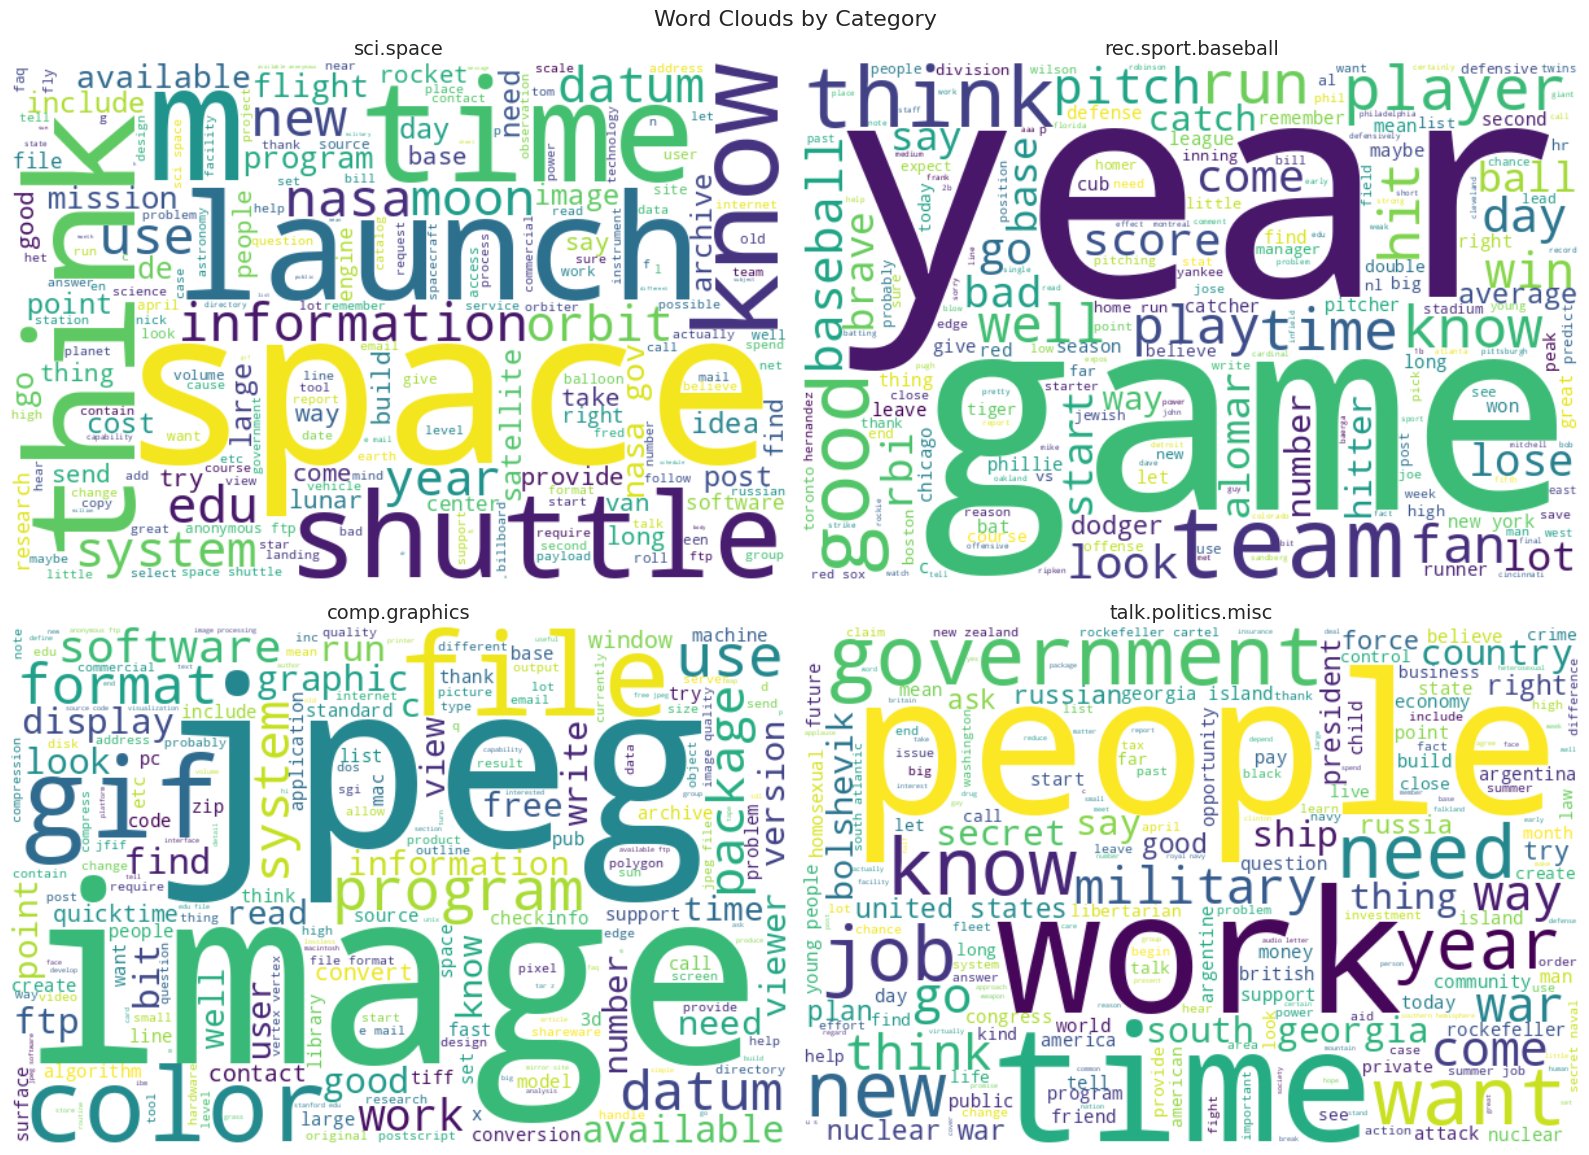

In [26]:
# Word cloud per category
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for ax, category in zip(axes.flat, df_sample['category'].unique()):
    # Get documents for this category
    category_indices = df_sample[df_sample['category'] == category].index.tolist()
    category_docs = [docs[i] for i in category_indices if i < len(docs)]

    # Extract lemmas
    category_lemmas = []
    for doc in category_docs:
        for token in doc:
            if not token.is_punct and not token.is_space and not token.is_stop:
                category_lemmas.append(token.lemma_.lower())

    if category_lemmas:
        text = ' '.join(category_lemmas)
        wc = WordCloud(width=600, height=400, background_color='white', colormap='viridis').generate(text)
        ax.imshow(wc, interpolation='bilinear')
        ax.set_title(category, fontsize=14)
    ax.axis('off')

plt.suptitle('Word Clouds by Category', fontsize=16)
plt.tight_layout()
plt.show()

# Sentence Analysis

In [27]:
# Analyze sentence lengths
sentence_lengths = []
sentences_per_doc = []

for doc in docs:
    doc_sentences = list(doc.sents)
    sentences_per_doc.append(len(doc_sentences))
    for sent in doc_sentences:
        sentence_lengths.append(len(sent))

print(f"Total sentences: {len(sentence_lengths)}")
print(f"Average sentence length: {np.mean(sentence_lengths):.1f} tokens")
print(f"Average sentences per document: {np.mean(sentences_per_doc):.1f}")

Total sentences: 5776
Average sentence length: 23.1 tokens
Average sentences per document: 11.6


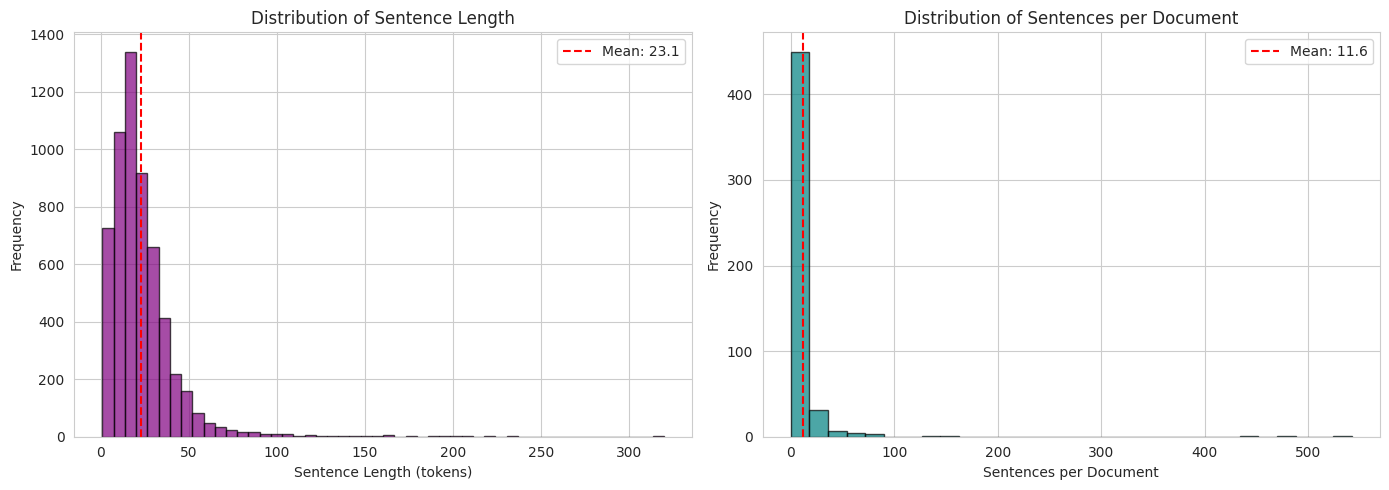

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sentence length distribution
axes[0].hist(sentence_lengths, bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[0].set_xlabel('Sentence Length (tokens)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Sentence Length')
axes[0].axvline(np.mean(sentence_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(sentence_lengths):.1f}')
axes[0].legend()

# Sentences per document
axes[1].hist(sentences_per_doc, bins=30, edgecolor='black', alpha=0.7, color='teal')
axes[1].set_xlabel('Sentences per Document')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Sentences per Document')
axes[1].axvline(np.mean(sentences_per_doc), color='red', linestyle='--', label=f'Mean: {np.mean(sentences_per_doc):.1f}')
axes[1].legend()

plt.tight_layout()
plt.show()

# Dependency Parsing Visualization

Let's visualize the dependency structure of a sample sentence using displacy.

In [29]:
from spacy import displacy

# Find a good sample sentence (not too long, not too short)
sample_doc = docs[0]
sample_sentences = [sent for sent in sample_doc.sents if 5 < len(sent) < 15]

if sample_sentences:
    sample_sent = sample_sentences[0]
    print(f"Sample sentence: {sample_sent}")
    print()
    displacy.render(sample_sent, style='dep', jupyter=True)

Sample sentence: Another resource is your local chapter of the National Space Society. 




# NER Visualization

In [30]:
# Find a document with entities
for doc in docs[:20]:
    if len(doc.ents) >= 3:
        print("Sample document with entities:")
        displacy.render(doc[:200], style='ent', jupyter=True)
        break

Sample document with entities:


# Summary Statistics

In [31]:
# Create a summary table
summary = {
    'Total Documents': len(df),
    'Sample Size (processed)': sample_size,
    'Categories': len(df['category'].unique()),
    'Avg Words per Document': f"{df['word_count'].mean():.1f}",
    'Total Tokens (sample)': len(all_tokens),
    'Unique Tokens (sample)': len(set(all_tokens)),
    'Unique Lemmas (sample)': len(set(all_lemmas)),
    'Vocabulary Reduction (lemmatization)': f"{(1 - len(set(all_lemmas))/len(set(all_tokens_no_stop)))*100:.1f}%",
    'Total Entities Found': len(entities),
    'Unique Entity Types': len(set(entity_labels)),
    'Avg Sentences per Document': f"{np.mean(sentences_per_doc):.1f}",
    'Avg Tokens per Sentence': f"{np.mean(sentence_lengths):.1f}"
}

summary_df = pd.DataFrame(list(summary.items()), columns=['Metric', 'Value'])
summary_df

,Metric,Value
0,Total Documents,2239
1,Sample Size (processed),500
2,Categories,4
3,Avg Words per Document,186.6
4,Total Tokens (sample),99653
5,Unique Tokens (sample),12717
6,Unique Lemmas (sample),10697
7,Vocabulary Reduction (lemmatization),13.9%
8,Total Entities Found,8951
9,Unique Entity Types,18


# Key Takeaways

In this EDA we:

1. **Loaded and explored** the 20 Newsgroups dataset
2. **Analyzed text length** distributions (characters, words, sentences)
3. **Compared preprocessing** effects (tokens vs lemmas, with/without stopwords)
4. **Examined POS tag** distributions
5. **Extracted and visualized** named entities
6. **Created word clouds** for the overall corpus and by category
7. **Used displacy** to visualize dependency parsing and NER

These techniques form the foundation for understanding any text dataset before building models.